# Laboratorio 2 - Clustering (Agrupación)
## ISIS-3301 - Inteligencia de Negocios

### Integrantes
- Juliana Durán
- Ana Critina Rodriguez
- Felipe Mesa

### Division de roles
- Juliana Durán: Estudiante 1 (carga y preparacion de los datos, y K-means)
- Ana Critina Rodriguez: Estudiante 2 (Algortimo Mean Shift)
- Felipe Mesa: Estudiante 3 (Algoritmo de DBscan)

### Carga de libreias y datos

In [100]:
#librerias
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette("pastel")

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

#REGRESION LINEAL
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

import scipy.stats as stats

import statsmodels.api as sm

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

from sklearn import tree

print("Carga de librerías hecha")


Carga de librerías hecha


In [101]:
#Cargo los datos a un data frame
df = pd.read_csv("Datos_SenecaféAlpes.csv", sep=";")
df.shape

(14291, 19)

### Limpieza y transformación de datos

Al hacer un análisis de los datos concluí que:

* Unicidad: detecté filas duplicadas, esto es crítico porque un mismo grano contado dos veces sesga las distribuciones y las distancias del clustering. 
* Completitud: encontré porcentajes no chiquitos de valores faltantes tanto en variables geométricas como en categóricas.
* Validez: observé valores físicamente imposibles (áreas, perímetros y ejes ≤ 0) y proporciones fuera del dominio natural [0,1] (medida, solidez, redondez, compacidad, excentricidad).
* Consistencia: las categóricas presentaban variantes de escritura (mayúsculas), por ejemplo “Lavado” vs “lavado”. Esto fragmenta categorías en varias etiquetas artificiales y produce columnas dummy redundantes al codificar. 

Esto lo solucioné haciendo:

* Eliminé duplicados con drop_duplicates.
* Normalicé texto en categóricas (minúsculas) y reconvertí “nan” de texto a NaN real, porque solo así los métodos de imputación reconocen faltantes y evitan crear categorías falsas.
* Apliqué reglas de negocio: marqué como NaN los valores imposibles (magnitudes que deben ser > 0 y proporciones que deben estar en [0,1]) para que no contaminen medianas ni percentiles y no empujen centroides de forma errónea.
* Imputé con mediana en numéricas y con moda en categóricas; retiré DefectoVisible al no aportar al objetivo analítico según su patrón de faltantes y variación, simplificando el espacio de características.
* Apliqué capping IQR en numéricas para atenuar outliers sin eliminar observaciones; esto reduce la influencia desproporcionada de pocos extremos sobre las distancias y estabiliza el comportamiento de K-Means y métodos basados en distancia.
* Hice one hot para Relacionaspecto y Metodosecado para llevar texto a formato numérico sin perder categorías, permitiendo integrar estas señales cualitativas en el clustering junto con las métricas geométricas.


In [102]:
# Reviso las primeras 5 filas del data frame para ver como son los datos.
# Me di cuenta que en RelacionAspecto hay erroes con alagrado y Alargado, son la misma clase pero escrito de distintas formas
df.head(5)

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
0,G006149,50836,923618.0,358.515147,181.388899,alargado,NaN,NaN,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,NaN,64158.0,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,NaN,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.0,NaN,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


In [103]:
#Reviso el tipo de variable que le asigno pandas a cada variable y la reviso.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14291 entries, 0 to 14290
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14291 non-null  object 
 1   Area                 14291 non-null  int64  
 2   Perimetro            13054 non-null  float64
 3   LongitudEjeMayor     13890 non-null  float64
 4   LongitudEjeMenor     14291 non-null  float64
 5   RelacionAspecto      13825 non-null  object 
 6   Excentricidad        13687 non-null  float64
 7   AreaConvexa          12868 non-null  float64
 8   DiametroEquivalente  12368 non-null  float64
 9   Medida               14291 non-null  float64
 10  Solidez              11985 non-null  float64
 11  Redondez             12228 non-null  float64
 12  Compacidad           13641 non-null  float64
 13  FactorForma1         13172 non-null  float64
 14  FactorForma2         13185 non-null  float64
 15  FactorForma3         13813 non-null 

In [104]:
#Quito los duplicados para garantizar la Unicidad
df.drop_duplicates()

#Y miro las estadisticas de cada variable para ver si hay outliers y cosas que no tienen sentido.
# Ej: no tiene sentido que haya un area de -63716.
# Esto revisa la Validez y que los datos sigan las reglas de negocio.
df.describe()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4
count,14291.000000,1.305400e+04,13890.000000,14291.000000,13687.000000,12868.000000,12368.000000,14291.000000,11985.000000,12228.000000,13641.000000,13172.000000,13185.000000,13813.000000,13132.000000
mean,53055.408999,7.729870e+05,319.985592,202.178613,0.749977,53575.397809,253.001741,0.749844,0.986774,0.873080,0.799242,0.006560,0.001712,0.643183,0.994292
std,29396.080372,3.266493e+05,86.378452,45.494541,0.099438,29566.387814,60.542330,0.050774,0.025947,0.063237,0.067643,0.001164,0.000601,0.100857,0.039081
min,-62716.000000,-1.012143e+06,-421.444657,-200.838672,-0.835004,-78423.000000,-448.402605,-0.798706,-0.989042,-0.896861,-0.843901,-0.007982,-0.002673,-0.683269,-0.998527
25%,36338.000000,6.768608e+05,253.319858,175.881052,0.715144,36720.000000,215.302463,0.718767,0.985597,0.832824,0.762127,0.005903,0.001151,0.581047,0.993663
50%,44660.000000,7.720345e+05,296.682345,192.437870,0.764392,45107.500000,238.579492,0.760232,0.988279,0.883353,0.800994,0.006645,0.001691,0.641648,0.996377
75%,61311.000000,9.554098e+05,376.548109,216.847844,0.810441,62109.250000,279.672481,0.786942,0.989991,0.916803,0.834405,0.007273,0.002169,0.696366,0.997889
max,254616.000000,1.921685e+06,738.860154,460.198497,0.911423,251082.000000,569.374358,0.866195,0.994378,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


In [105]:
# Reviso los duplicados de cada variable (Esto luego se solucionara)
df.isnull().sum()
(df.isnull().mean() * 100).round(2)

ID                      0.00
Area                    0.00
Perimetro               8.66
LongitudEjeMayor        2.81
LongitudEjeMenor        0.00
RelacionAspecto         3.26
Excentricidad           4.23
AreaConvexa             9.96
DiametroEquivalente    13.46
Medida                  0.00
Solidez                16.14
Redondez               14.44
Compacidad              4.55
FactorForma1            7.83
FactorForma2            7.74
FactorForma3            3.34
FactorForma4            8.11
DefectoVisible         20.54
MétodoSecado            4.11
dtype: float64

In [106]:
mask_invalid = df["Area"] <= 0
df.loc[mask_invalid, "Area"] = np.nan
print("# nulos tras marcar inválidos:", df["Area"].isna().sum())


# nulos tras marcar inválidos: 3


In [107]:
# Separar columnas por tipo
num_cols = df.select_dtypes(include=['float64','int64']).columns
cat_cols = ["RelacionAspecto", "DefectoVisible", "MétodoSecado"]


In [108]:

from sklearn.impute import SimpleImputer
# Normalizar texto: minúsculas + quitar espacios adelante/atrás
for col in cat_cols:
    df[col] = df[col].str.strip().str.lower()
    
# Puse esto porque al momento de revisar las categoricas me di cuenta que NaN lo paso nan y en la imputación ya no los reconocia.
# Normalice primero para que de una vez se imputaran los datos con una moda correcta, no domo "Alargado" cuando deberia ser "alargado".
for col in cat_cols:
    df[col] = df[col].replace("nan", np.nan)
   
# Imputación categórica con moda
imputer_cat = SimpleImputer(strategy="most_frequent")
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("Revisar si quedaron bien las categoricas")
# Revisar valores únicos después de normalizar
for col in cat_cols:
    print(df[col].value_counts())


Revisar si quedaron bien las categoricas
RelacionAspecto
alargado      12542
redondeado     1749
Name: count, dtype: int64
DefectoVisible
normal    14291
Name: count, dtype: int64
MétodoSecado
lavado     8399
natural    5815
honey        77
Name: count, dtype: int64


In [109]:
import numpy as np
from sklearn.impute import SimpleImputer

#division de variables numericas
positivos = [
    "Area","Perimetro","LongitudEjeMayor","LongitudEjeMenor",
    "AreaConvexa","DiametroEquivalente",
]
proporciones_01 = ["Medida","Solidez","Redondez","Compacidad","Excentricidad"]  # todas en [0,1]

#revisar las reglas de negocio (validez)
#revisar que los positivos sean positivos y si no poner NaN
for c in positivos:
    if c in num_cols:
        m = df[c] <= 0
        if m.any():
            print(f"  - {c} <= 0  → {int(m.sum())} casos")
            df.loc[m, c] = np.nan

#revisar que los que estan entre 1 y 0 esten entre 1 y 0 o si no poner NaN.
for c in proporciones_01:
    if c in num_cols:
        m_low  = df[c] < 0
        m_high = df[c] > 1
        n = int((m_low | m_high).sum())
        if n > 0:
            df.loc[m_low | m_high, c] = np.nan

#imputacion con la media
imputer_num = SimpleImputer(strategy="median")
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# tratar outliers
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df[col] = df[col].clip(lower=low, upper=high)  # capear valores
    
print("NaN numéricos después de imputar:", int(df[num_cols].isnull().sum().sum()))
df.head(5)


  - Perimetro <= 0  → 6 casos
  - LongitudEjeMayor <= 0  → 3 casos
  - LongitudEjeMenor <= 0  → 4 casos
  - AreaConvexa <= 0  → 6 casos
  - DiametroEquivalente <= 0  → 7 casos
NaN numéricos después de imputar: 0


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
0,G006149,50836.0,923618.00,358.515147,181.388899,alargado,0.764425,45113.5,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,normal,lavado
1,G007234,62764.0,1003767.00,409.207082,198.330199,alargado,0.764425,64158.0,282.689948,0.703995,0.981375,0.782807,0.690824,0.006520,0.000916,0.477237,0.988349,normal,natural
2,G007054,59965.0,994266.00,389.088529,197.967275,alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,normal,natural
3,G006619,55035.0,315405.75,379.346822,185.390577,alargado,0.872446,55591.0,238.592833,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,normal,lavado
4,G013353,39324.0,737773.00,262.520242,191.176858,alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,normal,lavado


In [110]:
import pandas as pd

# borrar DefectoVisible porque para todas sus columnas el unico valor es "normal"
for col in ["DefectoVisible"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
cat_cols = ["RelacionAspecto", "MétodoSecado"]

#sabemos que no hay erroes por differentes spellings entonces eso no lo correjimos
#le hacemos one hot a las variables categoricas.
dummies = pd.get_dummies(df[cat_cols], drop_first=False)

# quitar originales y añadir dummies 
df.drop(columns=cat_cols, inplace=True)
for col in dummies.columns:
        df[col] = dummies[col]

df.head(5)


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,...,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,RelacionAspecto_alargado,RelacionAspecto_redondeado,MétodoSecado_honey,MétodoSecado_lavado,MétodoSecado_natural
0,G006149,50836.0,923618.00,358.515147,181.388899,0.764425,45113.5,254.413847,0.804762,0.983840,...,0.709632,0.007052,0.001103,0.503578,0.995321,True,False,False,True,False
1,G007234,62764.0,1003767.00,409.207082,198.330199,0.764425,64158.0,282.689948,0.703995,0.981375,...,0.690824,0.006520,0.000916,0.477237,0.988349,True,False,False,False,True
2,G007054,59965.0,994266.00,389.088529,197.967275,0.860886,60910.0,276.314692,0.661581,0.984485,...,0.710159,0.006489,0.001018,0.504326,0.991211,True,False,False,False,True
3,G006619,55035.0,315405.75,379.346822,185.390577,0.872446,55591.0,238.592833,0.799695,0.989998,...,0.697811,0.006893,0.001008,0.486941,0.996380,True,False,False,True,False
4,G013353,39324.0,737773.00,262.520242,191.176858,0.685326,39758.0,223.760747,0.775392,0.989084,...,0.852356,0.006676,0.002174,0.726511,0.997630,True,False,False,True,False


In [111]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])  


df.head(5)

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,...,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,RelacionAspecto_alargado,RelacionAspecto_redondeado,MétodoSecado_honey,MétodoSecado_lavado,MétodoSecado_natural
0,G006149,0.034826,0.594863,0.516467,-0.525336,0.112925,-0.275598,0.175866,1.132991,-1.302554,...,-1.498358,0.451462,-1.060724,-1.445969,-0.053139,True,False,False,True,False
1,G007234,0.669449,0.956304,1.159135,-0.006807,0.112925,0.827667,0.859506,-0.962929,-2.133450,...,-1.811427,-0.077348,-1.387132,-1.719393,-2.337345,True,False,False,False,True
2,G007054,0.520530,0.913458,0.904074,-0.017915,1.319213,0.639508,0.705370,-1.845146,-1.085040,...,-1.489588,-0.108305,-1.209225,-1.438204,-1.399613,True,False,False,False,True
3,G006619,0.258231,-2.147940,0.780569,-0.402855,1.463777,0.331373,-0.206643,1.027599,0.773443,...,-1.695114,0.293043,-1.226400,-1.618666,0.293687,True,False,False,True,False
4,G013353,-0.577665,-0.243226,-0.700548,-0.225752,-0.876243,-0.585847,-0.565243,0.522103,0.465187,...,0.877312,0.077592,0.805439,0.868178,0.703333,True,False,False,True,False


### Modelado

k-Measn

k-Means es un algoritmo de clustering no supervisado que agrupa observaciones en K conjuntos minimizando la suma de distancias al cuadrado de cada punto a su centroide (media del cluster). Trabaja en ciclos: asigna cada punto al centroide más cercano (por distancia euclidiana) y luego recalcula los centroides como la media de los puntos asignados; repite hasta converger. Funciona mejor cuando los grupos son compactos y aproximadamente esféricos en el espacio de variables. Es sensible a la escala (por eso se estandarizan las variables continuas) y a outliers (conviene atenuarlos).

Cosas clave: 

1. Trazo el codo (inertia vs K): veo que la caída fuerte de la inercia se desacelera alrededor de K≈4–5. Por eso fijo k_auto=5 como candidato del codo.
2. Valido con silhouette solo en los candidatos (K=2,3,4,5,6): el mayor silhouette aparece en K=2, lo que indica mejor equilibrio entre cohesión interna y separación entre grupos. 
Modelo final (K-Means, K=2)

Pasos: 

1. Entrenamiento: KMeans con init=k-means++, n_init=50 y random_state=42.
2. Calidad: silhouette ≈ 0.360 ⇒ separación razonable para este dataset.
3. Tamaños: Cluster 0 ≈ 8,326 y Cluster 1 ≈ 5,965 ⇒ solución balanceada, sin clusters diminutos.
4. Perfiles (z-score en continuas; proporciones en dummies):
   * Cluster 1: Área, Perímetro, Longitud de ejes, ÁreaConvexa, Diámetro y Excentricidad más altos; Redondez y Compacidad más bajas → granos más grandes y alargados; dummies coherentes con “alargado”.
   * Cluster 0: patrón contrario → granos más pequeños y más redondeados; mayor proporción de “lavado”.
5. Exportable: genero “clusters_K-means_k2.csv” con ID y Cluster sin modificar el DataFrame original.

Conclusión:

El dataset se organiza de forma natural en dos segmentos: uno de granos más grandes y alargados y otro de granos más pequeños y redondeados. La solución con K=2 es coherente (silhouette razonable, tamaños equilibrados) y las variables diferenciadoras coinciden con la interpretación morfológica esperada.


In [112]:
# columnas one hot
dummy_cols = [c for c in df.columns if c.startswith('RelacionAspecto') or c.startswith('MétodoSecado')]

# columnas numericas
cont_cols = [c for c in df.columns 
             if (df[c].dtype != 'object') and (c not in dummy_cols) and (c != 'ID')]

#  matriz k menas
X = df[cont_cols + dummy_cols]

print("dummies:", dummy_cols)
print("shape X:", X.shape)
#revison limpieza datos
print("NaN en X?:", X.isnull().sum().sum())


dummies: ['RelacionAspecto_alargado', 'RelacionAspecto_redondeado', 'MétodoSecado_honey', 'MétodoSecado_lavado', 'MétodoSecado_natural']
shape X: (14291, 20)
NaN en X?: 0


 K       inertia  inertia_drop  rel_drop_%
 2 134411.631453           NaN         NaN
 3 110644.282190  23767.349263   17.682509
 4  92168.617185  18475.665005   16.698256
 5  83792.673752   8375.943433    9.087631
 6  77899.696658   5892.977094    7.032807
 7  73465.826947   4433.869711    5.691768
 8  69431.491139   4034.335808    5.491445
 9  65880.960449   3550.530690    5.113718
10  62991.822985   2889.137464    4.385391


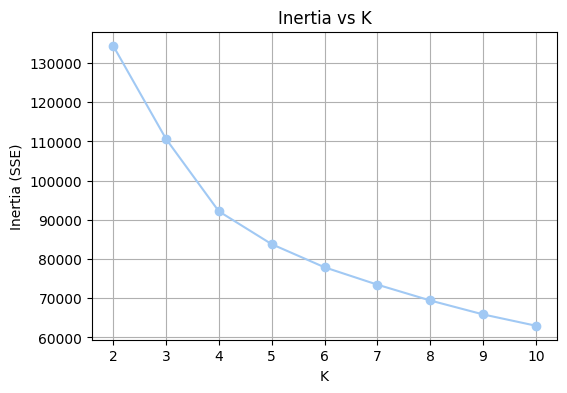

In [113]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Ks = list(range(2, 11))
#no con k=1 porque no es para clustering.
inertias = []

for k in Ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=25, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

# tabla
elbow_df = pd.DataFrame({"K": Ks, "inertia": inertias})
elbow_df["inertia_drop"] = elbow_df["inertia"].shift(1) - elbow_df["inertia"]
elbow_df["rel_drop_%"]  = 100 * elbow_df["inertia_drop"] / elbow_df["inertia"].shift(1)
print(elbow_df.to_string(index=False))

# gráfica del codo
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.title("Inertia vs K")
plt.xlabel("K"); plt.ylabel("Inertia (SSE)")
plt.xticks(Ks); plt.grid(True)
plt.show()




In [114]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# saca la silhiutte dde cada k
def evaluar_silhouette(X, K_list):
    filas = []
    for k in K_list:
        if k < 2:
            continue
        km = KMeans(n_clusters=k, init="k-means++", n_init=25, random_state=42)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        filas.append({"K": k, "silhouette": sil, "inertia": km.inertia_})
    return pd.DataFrame(filas).sort_values("K")

# concluí que el k_auto es 5 porque de 5 para adelante el intertia%drop es menor que 10%, y considero que un cambio de 10% no vale la pena.
k_auto = 5

# candidatos: k_auto-1, k_auto, k_auto+1 + 2 y 3 por si acaso
K_list = sorted(set([k_auto-1, k_auto, k_auto+1, 2, 3]))  # => [2,3,4,5,6]

val_df = evaluar_silhouette(X, K_list)
print(val_df.to_string(index=False))

# escoger el mejor K por silhouette entre candidatos
K_mejor = int(val_df.loc[val_df["silhouette"].idxmax(), "K"])
print("Mejor k: ", K_mejor)


 K  silhouette       inertia
 2    0.360114 134411.631453
 3    0.294467 110644.282190
 4    0.276172  92168.617185
 5    0.235286  83792.673752
 6    0.221650  77899.696658
Mejor k:  2


In [115]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.metrics import silhouette_score

K = K_mejor  # usa el elegido arriba
km_final = KMeans(n_clusters=K, init="k-means++", n_init=50, random_state=42)
labels = km_final.fit_predict(X)

# métricas y tamaños
sil = silhouette_score(X, labels)
sizes = pd.Series(labels).value_counts().sort_index()
print(f"K={K} | silhouette={sil:.3f}")
print("Tamaño por cluster:\n", sizes)

# perfil de clusters (z-scores en continuas; proporciones en dummies)
perfil = pd.DataFrame(X, columns=X.columns).assign(Cluster=labels).groupby("Cluster").mean()
print("\nPerfil (medias por variable):")
print(perfil.to_string())



K=2 | silhouette=0.360
Tamaño por cluster:
 0    8326
1    5965
Name: count, dtype: int64

Perfil (medias por variable):
             Area  Perimetro  LongitudEjeMayor  LongitudEjeMenor  Excentricidad  AreaConvexa  DiametroEquivalente    Medida   Solidez  Redondez  Compacidad  FactorForma1  FactorForma2  FactorForma3  FactorForma4  RelacionAspecto_alargado  RelacionAspecto_redondeado  MétodoSecado_honey  MétodoSecado_lavado  MétodoSecado_natural
Cluster                                                                                                                                                                                                                                                                                                                                 
0       -0.668316  -0.483123         -0.695328         -0.498435      -0.517944    -0.646057            -0.636776  0.163979  0.360728  0.604023    0.545152      0.456299      0.665226      0.541397      0.475922          

In [116]:
out = pd.DataFrame({
        "ID": df["ID"].astype(str),
        "Cluster": labels
    })
out.to_csv("clusters_K-means_k2.csv", index=False)
print("\nArchivo guardado: clusters_K-means_k2.csv")




Archivo guardado: clusters_K-means_k2.csv


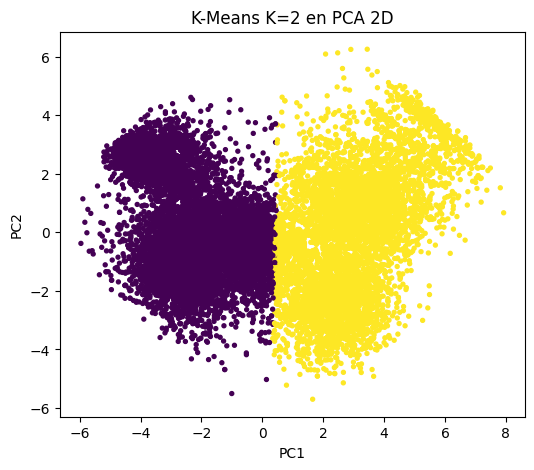

In [117]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=8)
plt.title("K-Means K=2 en PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# Mean Shift

Mean Shift es un algoritmo de clustering basado en densidad que no requiere especificar el número de clusters desde el inicio. Su idea principal es considerar cada punto de datos y desplazarlo iterativamente hacia la región de mayor densidad en su vecindad (estimada con un kernel). Los clusters se forman en torno a estos modos de densidad. A diferencia de K-Means, que asume clusters de forma esférica y requiere definir k, Mean Shift detecta automáticamente cuántos clusters existen en los datos.

In [118]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

Se incluyeron variables numéricas y variables categóricas transformadas mediante One-Hot Encoding. Esto garantiza que el algoritmo tenga en cuenta tanto las características geométricas como los factores categóricos (relación de aspecto, método de secado).

A continuación se escalarán esos datos, ya que Mean Shift se basa en distancias, por lo que es necesario que todas las variables “pesen lo mismo” en el cálculo de distancias. 

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape de X_scaled:", X_scaled.shape)

Shape de X_scaled: (14291, 20)


Estimar automáticamente el bandwidth para decidir el número de clusters: 
Se utilizará bandwidth controla que los valores grandes generen menos clusters (más generales) y valores pequeños generen más clusters (más específicos). Esto lo hace buscando "picos" de densidad en los datos. 

En este caso utilizaré estimate_bandwidth con el fin de no tener que definir manualmente el bandwidth, la función lo estima automáticamente a partir de la distribución de los datos.

Decisiones: 

- **quantile:** Se eligió 0.2 como un valor intermedio para balancear, de forma que no se tenga ni un cluster único ni un exceso de clusters. (los valores tipicos de quantile van desde 0.1 hasta 0.3)
- **n_samples:** estimate_bandwidth no necesita calcular distancias entre todos los puntos, porque sería muy costoso si tienes muchos datos, por lo que se esocgió una muestra de 1000, ya que es un valor suficientemente grande para dar una buena estimación, pero suficientemente pequeño para que el cálculo sea rápido.
- **random_state:** Esto controla la reproducibilidad al elegir la muestra de datos.El numero 42 es una convención muy común en ciencia de datos, por lo que se utlizará en este caso. 

In [120]:
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=1000, random_state=42)
print("Bandwidth estimado:", bandwidth)

Bandwidth estimado: 4.190202883231711


Entrenar Mean Shift

In [121]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels_ms = ms.fit_predict(X_scaled)

Numero de clusters encontrados

In [122]:
n_clusters_ms = len(np.unique(labels_ms))
print("Clusters encontrados (MeanShift):", n_clusters_ms)

Clusters encontrados (MeanShift): 2


Evaluacion de métricas

In [123]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [124]:
if n_clusters_ms > 1:
    sil = silhouette_score(X_scaled, labels_ms)
    ch = calinski_harabasz_score(X_scaled, labels_ms)
    db = davies_bouldin_score(X_scaled, labels_ms)
    print(f"Silhouette: {sil:.4f} | Calinski-Harabasz: {ch:.2f} | Davies-Bouldin: {db:.4f}")
else:
    sil = ch = db = np.nan
    print("Solo se formó 1 cluster -> métricas no aplican")

Silhouette: 0.3579 | Calinski-Harabasz: 4159.20 | Davies-Bouldin: 0.9638


Analisis de metricas: 
- **Silohuette:** Un 0.36 indica separación moderada, es decir que los clusters están diferenciados, pero todavía existe cierta superposición entre ellos (no hay fronteras muy definidas).
- **Calinski-Harabasz:** Un valor de 4159 es bastante elevado, lo que significa que los clusters están bien definidos en comparación con la variabilidad interna.
- **Davies-Bouldin:** Un 0.96 indica que los clusters tienen una separación aceptable, pero todavía con cierta similitud en las fronteras.

Guardar etiquetas en DataFrame

In [125]:
df["Cluster_MS"] = labels_ms

Perfil de clusters

In [126]:
perfil_ms = df.groupby("Cluster_MS").mean(numeric_only=True)
display(perfil_ms)

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,RelacionAspecto_alargado,RelacionAspecto_redondeado,MétodoSecado_honey,MétodoSecado_lavado,MétodoSecado_natural
Cluster_MS,,,,,,,,,,,,,,,,,,,,
0,0.080418,0.062253,0.124783,-0.017067,0.267947,0.077990,0.074823,-0.068659,-0.106055,-0.165152,-0.237281,0.032690,-0.209232,-0.247379,-0.123472,1.000000,0.000000,0.000080,0.541943,0.457977
1,-0.571825,-0.442660,-0.887291,0.121359,-1.905282,-0.554562,-0.532040,0.488214,0.754121,1.174341,1.687228,-0.232451,1.487777,1.759032,0.877966,0.007378,0.992622,0.043133,0.913167,0.043700


El Cluster 0 concentra la mayoría de las observaciones y representa granos con valores cercanos al promedio general. Sus métricas muestran formas más alargadas (relación de aspecto = 1), con áreas y perímetros estables y un reparto equilibrado entre los métodos de secado lavado (54%) y natural (46%). 

El Cluster 1 agrupa un subconjunto minoritario caracterizado por granos más pequeños, redondeados y compactos, con valores negativos en área y perímetro respecto a la media, muy baja excentricidad (menos alargados) y altos índices de redondez y compacidad. Este grupo se asocia principalmente al método de secado lavado (91%)

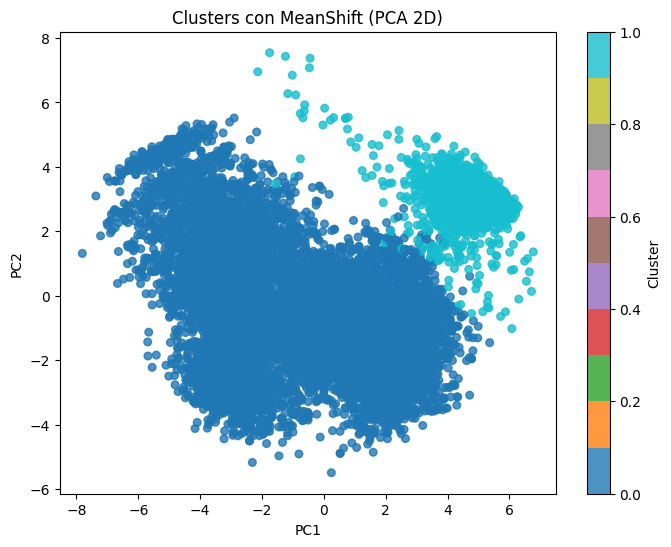

In [127]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducimos a 2D para visualizar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_ms, cmap="tab10", s=30, alpha=0.8)
plt.title("Clusters con MeanShift (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


Se puede observar que el algoritmo identificó principalmente 2 grupos, pero uno significativamente más grande que el otro (azul oscuro más grande que azul claro). 

El cluster de azul oscuro (0) contiene la mayoría de las observaciones, lo que indica que los datos están muy concentrados en una sola región del espacio. 

Mientras tanto, el cluster más pequeño (1) agrupa un subconjunto más definido hacia la parte superior derecha del gráfico. 

Aunque el cluster 1 se ve relativamente separado del 0, estos no están completamente aislados, y hay cierta superposición entre estos. Esto explica por qué las metricas de evaluacion, como silohuete fueron tan latas, porque no hay fronteras muy limpias entre los datos de los clusters

In [128]:
df["Cluster_MS"].value_counts()


Cluster_MS
0    12529
1     1762
Name: count, dtype: int64

# DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering basado en densidad que identifica clusters de puntos densamente agrupados y marca como ruido (outliers) aquellos puntos que están en regiones de baja densidad. A diferencia de K-Means, DBSCAN no requiere especificar el número de clusters a priori y puede encontrar clusters de formas arbitrarias.

## ¿Cómo funciona DBSCAN?

El algoritmo se basa en dos parámetros principales:
- **eps (ε)**: El radio máximo de la vecindad alrededor de un punto
- **min_samples**: El número mínimo de puntos requeridos para formar una región densa (cluster)

DBSCAN clasifica los puntos en tres categorías:
1. **Core points (puntos núcleo)**: Puntos que tienen al menos `min_samples` puntos en su vecindario de radio `eps`
2. **Border points (puntos frontera)**: Puntos que están dentro del radio `eps` de un core point pero no son core points ellos mismos
3. **Noise points (ruido)**: Puntos que no son ni core ni border points

**Ventajas:**
- No requiere especificar el número de clusters
- Puede encontrar clusters de formas arbitrarias
- Robusto a outliers (los identifica como ruido)
- Determinista (siempre produce el mismo resultado)

**Desventajas:**
- Sensible a los hiperparámetros eps y min_samples
- Puede tener dificultades con clusters de densidades muy diferentes
- El rendimiento puede degradarse en espacios de alta dimensionalidad

## Preparación de los datos para DBSCAN

Para DBSCAN utilizaremos los mismos datos escalados que preparamos anteriormente, ya que el algoritmo es sensible a las diferencias de escala entre las variables.

In [129]:
# Importar DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Verificar que tenemos los datos escalados
print("Shape de X_scaled:", X_scaled.shape)
print("Datos escalados disponibles:", X_scaled is not None)

Shape de X_scaled: (14291, 20)
Datos escalados disponibles: True


## Determinación de hiperparámetros

Para DBSCAN, necesitamos determinar dos hiperparámetros clave:

### 1. Estimación de eps (epsilon)
Una técnica común es usar el gráfico de k-distance para encontrar el "codo" que indica un buen valor de eps. Calculamos la distancia al k-ésimo vecino más cercano para cada punto y ordenamos estas distancias.

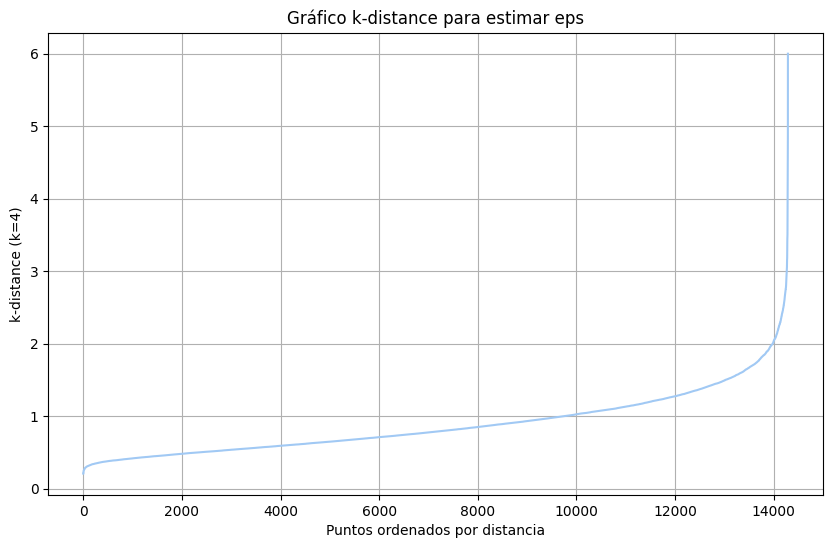

Índice del codo aproximado: 14290
Eps estimado: 5.9970

Percentiles de k-distance:
Percentil 90%: 1.4542
Percentil 95%: 1.7030
Percentil 98%: 2.0408
Percentil 99%: 2.3375


In [130]:
# Calcular k-distance para estimar eps
# Usaremos k=4 (una regla común es k = dimensiones - 1, pero aquí usaremos k=4)
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Ordenar las distancias al k-ésimo vecino
distances = np.sort(distances[:, k-1], axis=0)

# Graficar k-distance
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.ylabel('k-distance (k=4)')
plt.xlabel('Puntos ordenados por distancia')
plt.title('Gráfico k-distance para estimar eps')
plt.grid(True)
plt.show()

# Encontrar el "codo" aproximado
# Buscaremos donde la pendiente cambia más drásticamente
diff = np.diff(distances)
diff2 = np.diff(diff)
knee_idx = np.argmax(diff2) + 2  # +2 porque perdemos 2 elementos con los diffs
eps_estimated = distances[knee_idx]

print(f"Índice del codo aproximado: {knee_idx}")
print(f"Eps estimado: {eps_estimated:.4f}")

# También mostrar algunos percentiles para tener opciones
print("\nPercentiles de k-distance:")
for p in [90, 95, 98, 99]:
    print(f"Percentil {p}%: {np.percentile(distances, p):.4f}")

### 2. Experimentación con diferentes valores de eps y min_samples

Vamos a probar diferentes combinaciones de parámetros para encontrar la configuración óptima:

In [131]:
# Experimentar con diferentes valores de eps y min_samples
eps_values = [0.5, 0.7, 1.0, 1.2, 1.5]
min_samples_values = [5, 10, 15, 20]

results = []

for eps in eps_values:
    for min_samp in min_samples_values:
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels_db = dbscan.fit_predict(X_scaled)
        
        # Calcular métricas
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        n_noise = list(labels_db).count(-1)
        noise_ratio = n_noise / len(labels_db)
        
        # Calcular silhouette solo si hay más de 1 cluster y no todos son ruido
        if n_clusters > 1 and n_noise < len(labels_db):
            # Para silhouette, excluir puntos de ruido
            mask_no_noise = labels_db != -1
            if mask_no_noise.sum() > 0:
                sil_score = silhouette_score(X_scaled[mask_no_noise], labels_db[mask_no_noise])
            else:
                sil_score = -1
        else:
            sil_score = -1
            
        results.append({
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette': sil_score
        })

# Convertir a DataFrame para análisis
results_df = pd.DataFrame(results)
print("Resultados de experimentación con parámetros:")
print(results_df.to_string(index=False))

Resultados de experimentación con parámetros:
 eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
 0.5            5          53    11485     0.803653   -0.204056
 0.5           10          15    12799     0.895599    0.047874
 0.5           15           5    13615     0.952698    0.588784
 0.5           20           5    13941     0.975509    0.384858
 0.7            5          58     7804     0.546078   -0.037142
 0.7           10          20     9202     0.643902    0.188997
 0.7           15           9     9826     0.687566    0.293967
 0.7           20           5    10299     0.720663    0.430436
 1.0            5          58     3823     0.267511   -0.165379
 1.0           10          24     4977     0.348261   -0.007837
 1.0           15          14     5711     0.399622    0.049788
 1.0           20          12     6193     0.433350    0.145390
 1.2            5          60     2200     0.153943   -0.163927
 1.2           10          18     3086     0.215940   -0.0

In [132]:
# Seleccionar los mejores parámetros basados en criterios múltiples
# Filtrar resultados con al menos 2 clusters, silhouette válido y menos del 50% de ruido
valid_results = results_df[
    (results_df['n_clusters'] >= 2) & 
    (results_df['silhouette'] > 0) & 
    (results_df['noise_ratio'] <= 0.5)  # Menos del 50% de ruido
]

if len(valid_results) > 0:
    # Ordenar por silhouette descendente y luego por noise_ratio ascendente
    valid_results = valid_results.sort_values(['silhouette', 'noise_ratio'], ascending=[False, True])
    
    print("Mejores combinaciones de parámetros (con <50% ruido):")
    print(valid_results.head(10).to_string(index=False))
    
    # Seleccionar los mejores parámetros
    best_params = valid_results.iloc[0]
    best_eps = best_params['eps']
    best_min_samples = int(best_params['min_samples'])
    
    print(f"\nMejores parámetros seleccionados:")
    print(f"eps: {best_eps}")
    print(f"min_samples: {best_min_samples}")
    print(f"Silhouette: {best_params['silhouette']:.4f}")
    print(f"N clusters: {best_params['n_clusters']}")
    print(f"% Ruido: {best_params['noise_ratio']:.2%}")
else:
    # Si no hay resultados válidos con poco ruido, relajar el criterio
    valid_results_relaxed = results_df[
        (results_df['n_clusters'] >= 2) & 
        (results_df['silhouette'] > 0)
    ]
    
    if len(valid_results_relaxed) > 0:
        # Buscar el mejor balance entre silhouette y poco ruido
        # Crear un score combinado: silhouette * (1 - noise_ratio)
        valid_results_relaxed['combined_score'] = valid_results_relaxed['silhouette'] * (1 - valid_results_relaxed['noise_ratio'])
        valid_results_relaxed = valid_results_relaxed.sort_values('combined_score', ascending=False)
        
        best_params = valid_results_relaxed.iloc[0]
        best_eps = best_params['eps']
        best_min_samples = int(best_params['min_samples'])
        
        print("No se encontraron parámetros con <50% ruido.")
        print("Seleccionando mejor balance entre calidad y ruido:")
        print(f"eps: {best_eps}")
        print(f"min_samples: {best_min_samples}")
        print(f"Silhouette: {best_params['silhouette']:.4f}")
        print(f"N clusters: {best_params['n_clusters']}")
        print(f"% Ruido: {best_params['noise_ratio']:.2%}")
        print(f"Score combinado: {best_params['combined_score']:.4f}")
    else:
        # Si no hay resultados válidos, usar parámetros por defecto
        best_eps = 1.0
        best_min_samples = 10
        print("No se encontraron parámetros válidos, usando valores por defecto:")
        print(f"eps: {best_eps}, min_samples: {best_min_samples}")

Mejores combinaciones de parámetros (con <50% ruido):
 eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
 1.0           20          12     6193     0.433350    0.145390
 1.5           20           9     1922     0.134490    0.143442
 1.5           15           9     1705     0.119306    0.130200
 1.5            5          19      883     0.061787    0.059604
 1.5           10          19     1270     0.088867    0.055315
 1.0           15          14     5711     0.399622    0.049788
 1.2           15          12     3626     0.253726    0.027694

Mejores parámetros seleccionados:
eps: 1.0
min_samples: 20
Silhouette: 0.1454
N clusters: 12.0
% Ruido: 43.33%


## Entrenamiento del modelo DBSCAN final

In [133]:
# Entrenar el modelo DBSCAN final con los mejores parámetros
dbscan_final = DBSCAN(eps=best_eps, min_samples=int(best_min_samples), metric='euclidean')
labels_dbscan = dbscan_final.fit_predict(X_scaled)

# Análisis de resultados
n_clusters_final = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_final = list(labels_dbscan).count(-1)
noise_ratio_final = n_noise_final / len(labels_dbscan)

print(f"Resultados del modelo DBSCAN final:")
print(f"Parámetros: eps={best_eps}, min_samples={best_min_samples}")
print(f"Número de clusters encontrados: {n_clusters_final}")
print(f"Número de puntos de ruido: {n_noise_final}")
print(f"Porcentaje de ruido: {noise_ratio_final:.2%}")

# Calcular métricas de calidad
if n_clusters_final > 1 and n_noise_final < len(labels_dbscan):
    # Métricas excluyendo puntos de ruido
    mask_no_noise = labels_dbscan != -1
    if mask_no_noise.sum() > 0:
        sil_final = silhouette_score(X_scaled[mask_no_noise], labels_dbscan[mask_no_noise])
        ch_final = calinski_harabasz_score(X_scaled[mask_no_noise], labels_dbscan[mask_no_noise])
        db_final = davies_bouldin_score(X_scaled[mask_no_noise], labels_dbscan[mask_no_noise])
        
        print(f"\nMétricas de calidad (sin ruido):")
        print(f"Silhouette Score: {sil_final:.4f}")
        print(f"Calinski-Harabasz Index: {ch_final:.2f}")
        print(f"Davies-Bouldin Index: {db_final:.4f}")
    else:
        print("Todos los puntos son ruido")
else:
    print("No se pueden calcular métricas: muy pocos clusters o demasiado ruido")

Resultados del modelo DBSCAN final:
Parámetros: eps=1.0, min_samples=20
Número de clusters encontrados: 12
Número de puntos de ruido: 6193
Porcentaje de ruido: 43.33%

Parámetros: eps=1.0, min_samples=20
Número de clusters encontrados: 12
Número de puntos de ruido: 6193
Porcentaje de ruido: 43.33%

Métricas de calidad (sin ruido):
Silhouette Score: 0.1454
Calinski-Harabasz Index: 1720.03
Davies-Bouldin Index: 1.0719

Métricas de calidad (sin ruido):
Silhouette Score: 0.1454
Calinski-Harabasz Index: 1720.03
Davies-Bouldin Index: 1.0719


In [134]:
# Análisis de tamaños de clusters y distribución
cluster_sizes = pd.Series(labels_dbscan).value_counts().sort_index()
print(f"\nDistribución de puntos por cluster:")
for cluster_id, size in cluster_sizes.items():
    if cluster_id == -1:
        print(f"Ruido: {size} puntos ({size/len(labels_dbscan):.2%})")
    else:
        print(f"Cluster {cluster_id}: {size} puntos ({size/len(labels_dbscan):.2%})")

# Agregar etiquetas al DataFrame original
df["Cluster_DBSCAN"] = labels_dbscan


Distribución de puntos por cluster:
Ruido: 6193 puntos (43.33%)
Cluster 0: 3422 puntos (23.95%)
Cluster 1: 2390 puntos (16.72%)
Cluster 2: 1101 puntos (7.70%)
Cluster 3: 105 puntos (0.73%)
Cluster 4: 403 puntos (2.82%)
Cluster 5: 188 puntos (1.32%)
Cluster 6: 141 puntos (0.99%)
Cluster 7: 62 puntos (0.43%)
Cluster 8: 144 puntos (1.01%)
Cluster 9: 50 puntos (0.35%)
Cluster 10: 58 puntos (0.41%)
Cluster 11: 34 puntos (0.24%)


## Perfil de clusters DBSCAN

In [135]:
# Analizar el perfil de cada cluster
perfil_dbscan = df.groupby("Cluster_DBSCAN").mean(numeric_only=True)

print("Perfil de clusters DBSCAN (medias por variable):")
display(perfil_dbscan)

# Analizar las características distintivas de cada cluster
print("\nAnálisis detallado por cluster:")
for cluster_id in sorted(df["Cluster_DBSCAN"].unique()):
    cluster_data = df[df["Cluster_DBSCAN"] == cluster_id]
    n_points = len(cluster_data)
    
    if cluster_id == -1:
        print(f"\n=== RUIDO (Outliers) ===")
        print(f"Cantidad de puntos: {n_points}")
        print("Estos son granos que DBSCAN considera atípicos o en regiones de baja densidad.")
    else:
        print(f"\n=== CLUSTER {cluster_id} ===")
        print(f"Cantidad de puntos: {n_points}")
        
        # Variables geométricas más distintivas (valores estandarizados)
        geometric_vars = ['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor', 
                         'Medida', 'Solidez', 'Redondez', 'Compacidad', 'Excentricidad']
        
        cluster_profile = perfil_dbscan.loc[cluster_id, geometric_vars]
        
        print("Características geométricas destacadas:")
        # Mostrar las 3 características más altas y más bajas
        top_features = cluster_profile.nlargest(3)
        bottom_features = cluster_profile.nsmallest(3)
        
        print("  Valores más altos:")
        for var, val in top_features.items():
            print(f"    - {var}: {val:.3f}")
            
        print("  Valores más bajos:")
        for var, val in bottom_features.items():
            print(f"    - {var}: {val:.3f}")
        
        # Análisis de variables categóricas
        categorical_vars = [col for col in df.columns if col.startswith(('RelacionAspecto', 'MétodoSecado'))]
        cat_profile = perfil_dbscan.loc[cluster_id, categorical_vars]
        
        print("  Distribución de variables categóricas:")
        for var, val in cat_profile.items():
            if val > 0.5:  # Solo mostrar las categorías dominantes
                print(f"    - {var}: {val:.1%}")

Perfil de clusters DBSCAN (medias por variable):


,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,...,FactorForma1,FactorForma2,FactorForma3,FactorForma4,RelacionAspecto_alargado,RelacionAspecto_redondeado,MétodoSecado_honey,MétodoSecado_lavado,MétodoSecado_natural,Cluster_MS
Cluster_DBSCAN,,,,,,,,,,,,,,,,,,,,,
-1,0.506783,0.205031,0.478432,0.411996,0.286843,0.478381,0.454815,-0.130536,-0.462532,-0.496529,...,-0.351179,-0.410895,-0.310234,-0.441633,0.914742,0.085258,0.012433,0.530115,0.457452,0.087357
0,-0.403032,-0.107332,-0.389856,-0.371951,-0.052454,-0.367435,-0.362826,0.688399,0.310751,0.410028,...,0.342898,0.233505,0.115386,0.239216,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,-0.611094,-0.250638,-0.551157,-0.601305,-0.026506,-0.602619,-0.578811,-0.712914,0.270336,0.389636,...,0.581973,0.326707,0.112258,0.371683,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,-0.600765,-0.323219,-0.910044,0.103935,-2.011930,-0.586753,-0.555590,0.546419,0.908002,1.277892,...,-0.239587,1.648088,1.843079,0.948281,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
3,-0.375343,-2.147940,-0.320179,-0.324548,0.101566,-0.352915,-0.315351,-0.823577,0.308708,0.198710,...,0.199740,0.026093,-0.027162,0.337334,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,0.175147,0.522122,0.717388,-0.492482,1.463677,0.212289,0.270820,-1.924167,0.028911,-1.466139,...,0.391387,-1.200851,-1.633880,-0.107081,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
5,0.204497,0.541968,0.738002,-0.459962,1.461613,0.248852,0.311558,0.989064,0.232544,-1.351344,...,0.362400,-1.207955,-1.628277,-0.147050,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
6,2.584600,2.304962,2.935219,2.439853,0.153806,2.377739,2.390801,0.892236,0.345193,-0.065622,...,-2.355157,-1.497105,-0.087456,-0.581902,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
7,-0.670609,-0.375782,-0.955005,0.001505,-2.059863,-0.644621,-0.678670,0.484818,0.895641,1.515140,...,-0.140632,-0.035642,1.853448,1.072716,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000



Análisis detallado por cluster:

=== RUIDO (Outliers) ===
Cantidad de puntos: 6193
Estos son granos que DBSCAN considera atípicos o en regiones de baja densidad.

=== CLUSTER 0 ===
Cantidad de puntos: 3422
Características geométricas destacadas:
  Valores más altos:
    - Medida: 0.688
    - Redondez: 0.410
    - Solidez: 0.311
  Valores más bajos:
    - Area: -0.403
    - LongitudEjeMayor: -0.390
    - LongitudEjeMenor: -0.372
  Distribución de variables categóricas:
    - RelacionAspecto_alargado: 100.0%
    - MétodoSecado_lavado: 100.0%
    - Medida: 0.688
    - Redondez: 0.410
    - Solidez: 0.311
  Valores más bajos:
    - Area: -0.403
    - LongitudEjeMayor: -0.390
    - LongitudEjeMenor: -0.372
  Distribución de variables categóricas:
    - RelacionAspecto_alargado: 100.0%
    - MétodoSecado_lavado: 100.0%

=== CLUSTER 1 ===
Cantidad de puntos: 2390
Características geométricas destacadas:
  Valores más altos:
    - Redondez: 0.390
    - Solidez: 0.270
    - Compacidad: 0.139
  

## Visualización de resultados DBSCAN

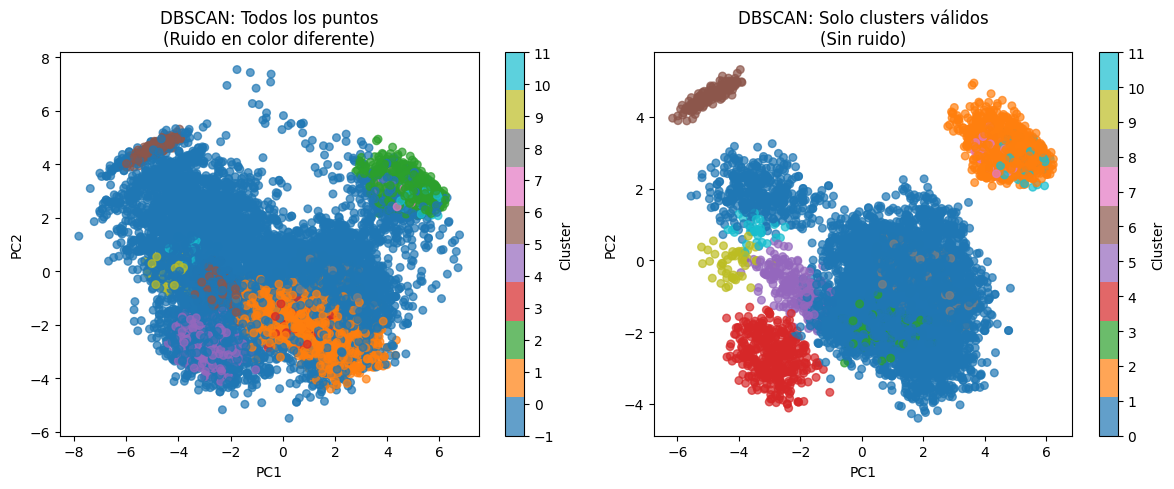

In [136]:
# Visualización en 2D usando PCA
plt.figure(figsize=(12, 5))

# Gráfico 1: Todos los puntos incluido el ruido
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='tab10', s=30, alpha=0.7)
plt.title('DBSCAN: Todos los puntos\n(Ruido en color diferente)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Crear colorbar personalizado
unique_labels = sorted(set(labels_dbscan))
cbar = plt.colorbar(scatter, ticks=unique_labels)
cbar.set_label('Cluster')

# Gráfico 2: Solo puntos que pertenecen a clusters (sin ruido)
plt.subplot(1, 2, 2)
mask_no_noise = labels_dbscan != -1
if mask_no_noise.sum() > 0:
    scatter2 = plt.scatter(X_pca[mask_no_noise, 0], X_pca[mask_no_noise, 1], 
                          c=labels_dbscan[mask_no_noise], cmap='tab10', s=30, alpha=0.7)
    plt.title('DBSCAN: Solo clusters válidos\n(Sin ruido)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    # Colorbar para clusters válidos
    valid_labels = sorted(set(labels_dbscan[mask_no_noise]))
    cbar2 = plt.colorbar(scatter2, ticks=valid_labels)
    cbar2.set_label('Cluster')
else:
    plt.text(0.5, 0.5, 'No hay clusters válidos\n(solo ruido)', 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)
    plt.title('DBSCAN: Solo clusters válidos')

plt.tight_layout()
plt.show()

## Comparación de los tres algoritmos de clustering

Ahora comparemos los resultados de los tres algoritmos implementados: K-Means, Mean Shift y DBSCAN.

In [137]:
# Calcular métricas para todos los algoritmos
algorithms_comparison = []

# 1. K-Means (K=2)
kmeans_labels = labels  # Ya calculado anteriormente
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
kmeans_ch = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)

algorithms_comparison.append({
    'Algoritmo': 'K-Means',
    'N_Clusters': len(set(kmeans_labels)),
    'N_Ruido': 0,
    'Silhouette': kmeans_sil,
    'Calinski-Harabasz': kmeans_ch,
    'Davies-Bouldin': kmeans_db,
    'Parámetros': f'k={len(set(kmeans_labels))}'
})

# 2. Mean Shift
ms_labels = labels_ms  # Ya calculado anteriormente
ms_n_clusters = len(set(ms_labels)) - (1 if -1 in ms_labels else 0)
ms_n_noise = list(ms_labels).count(-1)

if ms_n_clusters > 1:
    if ms_n_noise > 0:
        mask_ms = ms_labels != -1
        ms_sil = silhouette_score(X_scaled[mask_ms], ms_labels[mask_ms])
        ms_ch = calinski_harabasz_score(X_scaled[mask_ms], ms_labels[mask_ms])
        ms_db = davies_bouldin_score(X_scaled[mask_ms], ms_labels[mask_ms])
    else:
        ms_sil = silhouette_score(X_scaled, ms_labels)
        ms_ch = calinski_harabasz_score(X_scaled, ms_labels)
        ms_db = davies_bouldin_score(X_scaled, ms_labels)
else:
    ms_sil = ms_ch = ms_db = np.nan

algorithms_comparison.append({
    'Algoritmo': 'Mean Shift',
    'N_Clusters': ms_n_clusters,
    'N_Ruido': ms_n_noise,
    'Silhouette': ms_sil,
    'Calinski-Harabasz': ms_ch,
    'Davies-Bouldin': ms_db,
    'Parámetros': f'bandwidth={bandwidth:.3f}'
})

# 3. DBSCAN
db_labels = labels_dbscan  # Ya calculado anteriormente
db_n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
db_n_noise = list(db_labels).count(-1)

if db_n_clusters > 1 and db_n_noise < len(db_labels):
    mask_db = db_labels != -1
    db_sil = silhouette_score(X_scaled[mask_db], db_labels[mask_db])
    db_ch = calinski_harabasz_score(X_scaled[mask_db], db_labels[mask_db])
    db_db = davies_bouldin_score(X_scaled[mask_db], db_labels[mask_db])
else:
    db_sil = db_ch = db_db = np.nan

algorithms_comparison.append({
    'Algoritmo': 'DBSCAN',
    'N_Clusters': db_n_clusters,
    'N_Ruido': db_n_noise,
    'Silhouette': db_sil,
    'Calinski-Harabasz': db_ch,
    'Davies-Bouldin': db_db,
    'Parámetros': f'eps={best_eps}, min_samples={best_min_samples}'
})

# Crear tabla comparativa
comparison_df = pd.DataFrame(algorithms_comparison)
print("=== COMPARACIÓN DE ALGORITMOS DE CLUSTERING ===")
print(comparison_df.to_string(index=False))

=== COMPARACIÓN DE ALGORITMOS DE CLUSTERING ===
 Algoritmo  N_Clusters  N_Ruido  Silhouette  Calinski-Harabasz  Davies-Bouldin              Parámetros
   K-Means           2        0    0.306494        6868.364245        1.345364                     k=2
Mean Shift           2        0    0.357858        4159.200347        0.963849         bandwidth=4.190
    DBSCAN          12     6193    0.145390        1720.027957        1.071870 eps=1.0, min_samples=20
